# GLOBAL CMT DOWNLOADER

This is a python script to download directly the Global CMT solutions for a range of requested events, using the IRIS.edu query.

© Foivos Karakostas - INGV Bologna, 2022

In [1]:
import obspy
from obspy.clients.fdsn import Client as fdsnClient
from obspy.core import UTCDateTime
from obspy import read_events
import requests
import csv
import xml.etree.ElementTree as ET

##### Insert the region of the survey and the magnitudes of the requested events

In [2]:
print ('Global CMT solutions downloader from IRIS.edu database')
print ('© Foivos Karakostas - INGV Bologna, 2022')
print ('- - - - - - - - - - - - - - - - - - - - - - - - - - - -')
print (' ')
time1 = input('Starting time (year,month,day,Hour,Minute,Seconds): ')
time2 = input('Ending time (year,month,day,Hour,Minute,Seconds): ')
minlat = float(input('Minimum latitude (default = -90): ') or '-90')
maxlat = float(input('Maximum latitude (default = +90): ') or '90')
minlon = float(input('Minimum longitude (default = -180): ') or '-180')
maxlon = float(input('Maximum longitude (default = +180): ') or '180')
minmag = float(input('Minimum magnitude (Mw) (default = 6): ') or '6')
maxmag = float(input('Maximum magnitude (Mw) (default = 9.9): ') or '9.9')
starttime = UTCDateTime(time1)
endtime = UTCDateTime(time2)
c_fdsn = fdsnClient('IRIS')
cat = c_fdsn.get_events(minlatitude = minlat, maxlatitude = maxlat, minlongitude = minlon, maxlongitude = maxlon, minmagnitude=minmag, maxmagnitude=maxmag, starttime = starttime, endtime = endtime, includeallorigins=True)
print (' ')
print (str(len(cat)), ' event(s) found')
print (' ')
ns = {"q":"http://quakeml.org/xmlns/quakeml/1.2",
       "d":"http://quakeml.org/xmlns/bed/1.2",
        "catalog":"http://anss.org/xmlns/catalog/0.1",
        "tensor":"http://anss.org/xmlns/tensor/0.1"}
line01 = []; line02 = []; line03 = []; line04 = []; line05 = []; line06 = []; line07 = []; line08 = []; line09 = []
line10 = []; line11 = []; line12 = []; line13 = []; failed = 0; successful = 0
filename = 'CMTSOLUTIONS'
for e in range(0, len(cat)):
    eventtime = UTCDateTime(cat[e].origins[0].time)
    url = ('http://ds.iris.edu/spudservice/momenttensor/gcmtid/C' + str(eventtime.year).zfill(4) + str(eventtime.month).zfill(2) + str(eventtime.day).zfill(2) + str(eventtime.hour).zfill(2) + str(eventtime.minute).zfill(2) +'A/quakeml')
    r = requests.get(url, allow_redirects=True)
    r.raw.decode_content = True
    local_file = 'temp.xml'
    with open(local_file, 'wb')as file:
        file.write(r.content)  
    with open('temp.xml', 'r') as file :
        filedata = file.read()
        filedata = filedata.replace('&lt;', '<'); filedata = filedata.replace('&gt;', '>')
        filedata = filedata.replace('<pre>', ''); filedata = filedata.replace('<body>', '')
        filedata = filedata.replace('<html>', ''); filedata = filedata.replace('</pre>', '')
        filedata = filedata.replace('</body>', ''); filedata = filedata.replace('</html>', '')
    with open('temp.xml', 'w') as file:
        file.write(filedata)
    filetemp = open('temp.xml', 'r')
    Lines = filetemp.readlines()
    line2test = str(Lines[0])
    testline = line2test[0:9]
    if testline == 'Error 400':
        failed = failed + 1
        print('Processed successfully ',str("{:.0f}".format(successful).rjust(5)),' event(s) and ', str("{:.0f}".format(failed).rjust(5)),' event(s) failed - TOTAL: ', str("{:.0f}".format(e+1).rjust(5)), 'events or ', str("{:.2f}".format(((e+1)/len(cat))*100).rjust(6)), '% done', end='\r')
        #time.sleep(1)
    else:
        successful = successful + 1
        print('Processed successfully ',str("{:.0f}".format(successful).rjust(5)),' event(s) and ', str("{:.0f}".format(failed).rjust(5)),' event(s) failed - TOTAL: ', str("{:.0f}".format(e+1).rjust(5)), 'events or ', str("{:.2f}".format(((e+1)/len(cat))*100).rjust(6)), '% done', end='\r')
        #time.sleep(1)
        tree = ET.parse('temp.xml')
        root = tree.getroot()
        eventlist = root.findall('d:eventParameters',ns)
        cat2 = read_events('temp.xml','quakeml')
        Mwc = 0
        Mb = 0
        Magnitudes = cat2[0].magnitudes
        Magtype = []
        for o in range(0, len(Magnitudes)):
            Magtype.append(Magnitudes[o].magnitude_type)
            if Magtype[o] == 'Mwc':
                Mwc = Magnitudes[o].mag;
            if Magtype[o] == 'Mb':
                Mb = Magnitudes[o].mag;
        eventtime = cat2[0].origins[0].time;
        strmicro = str(eventtime.microsecond);
        line01.append(' PDEQ ' + str(eventtime.year).rjust(4) + ' ' + str(eventtime.month).rjust(2) + ' ' + str(eventtime.day).rjust(2) + ' ' + str(eventtime.hour).rjust(2) + ' ' + str(eventtime.minute).rjust(2) + ' ' + str(eventtime.second).rjust(2) + '.' + strmicro[0:2] + ' ' + str("{:-.4f}".format(cat2[0].origins[0].latitude)).rjust(8) + ' ' + str("{:-.4f}".format(cat2[0].origins[0].longitude)).rjust(8) + ' ' + str(cat2[0].origins[1].depth/1000) + '  ' + str("{:-.1f}".format(Mb)).rjust(3) + '  ' + str("{:-.1f}".format(Mwc)).rjust(3) + ' ' + cat2[0].event_descriptions[0].text)    
        enam = str(cat2[0].origins[0].resource_id)
        line02.append('event name:      ' + enam[50:-10])   
        # Find the time shift
        correctedtime = cat2[0].origins[1].time;
        timeshift = correctedtime - eventtime
        line03.append('time shift:      ' + str("{:.4f}".format(timeshift)).rjust(7))
        line04.append('half duration:   ' + str("{:.4f}".format(cat2[0].focal_mechanisms[0].moment_tensor.source_time_function.duration/2)).rjust(7))
        line05.append('latitude:       ' + str("{:-.4f}".format(cat2[0].origins[1].latitude)).rjust(8))
        line06.append('longitude:      ' + str("{:-.4f}".format(cat2[0].origins[1].longitude)).rjust(8))
        line07.append('depth:          ' + str("{:.4f}".format(cat2[0].origins[1].depth/1000)).rjust(8))
        line08.append('Mrr:       ' + str("{:-.6e}".format(cat2[0].focal_mechanisms[0].moment_tensor.tensor.m_rr*1e7)).rjust(13))
        line09.append('Mtt:       ' + str("{:-.6e}".format(cat2[0].focal_mechanisms[0].moment_tensor.tensor.m_tt*1e7)).rjust(13))
        line10.append('Mpp:       ' + str("{:-.6e}".format(cat2[0].focal_mechanisms[0].moment_tensor.tensor.m_pp*1e7)).rjust(13))
        line11.append('Mrt:       ' + str("{:-.6e}".format(cat2[0].focal_mechanisms[0].moment_tensor.tensor.m_rt*1e7)).rjust(13))
        line12.append('Mrp:       ' + str("{:-.6e}".format(cat2[0].focal_mechanisms[0].moment_tensor.tensor.m_rp*1e7)).rjust(13))
        line13.append('Mtp:       ' + str("{:-.6e}".format(cat2[0].focal_mechanisms[0].moment_tensor.tensor.m_tp*1e7)).rjust(13))
with open(filename, 'w') as f:
    for tt in range(0, len(line01)):
        f.write(line01[tt]); f.write('\n'); f.write(line02[tt]); f.write('\n'); f.write(line03[tt]); f.write('\n')
        f.write(line04[tt]); f.write('\n'); f.write(line05[tt]); f.write('\n'); f.write(line06[tt]); f.write('\n')
        f.write(line07[tt]); f.write('\n'); f.write(line08[tt]); f.write('\n'); f.write(line09[tt]); f.write('\n')
        f.write(line10[tt]); f.write('\n'); f.write(line11[tt]); f.write('\n'); f.write(line12[tt]); f.write('\n')
        f.write(line13[tt]); f.write('\n'); f.write('\n')    
print ('\n', end = '\n')
print ('The CMT catalog is ready, it is stored in the `CMTSOLUTIONS` file')

Global CMT solutions downloader from IRIS.edu database
© Foivos Karakostas - INGV Bologna, 2022
- - - - - - - - - - - - - - - - - - - - - - - - - - - -
 
Starting time (year,month,day,Hour,Minute,Seconds): 2012,1,1,0,0,0
Ending time (year,month,day,Hour,Minute,Seconds): 2022,7,4,12,0,0
Minimum latitude (default = -90): -55
Maximum latitude (default = +90): 75
Minimum longitude (default = -180): -94
Maximum longitude (default = +180): 112
Minimum magnitude (Mw) (default = 6): 6
Maximum magnitude (Mw) (default = 9.9): 9.5
 
439  event(s) found
 
Processed successfully    417  event(s) and     22  event(s) failed - TOTAL:    439 events or  100.00 % done

The CMT catalog is ready, it is stored in the `CMTSOLUTIONS` file


##### Generate a map of the focal mechanisms (beachballs) with pyGMT

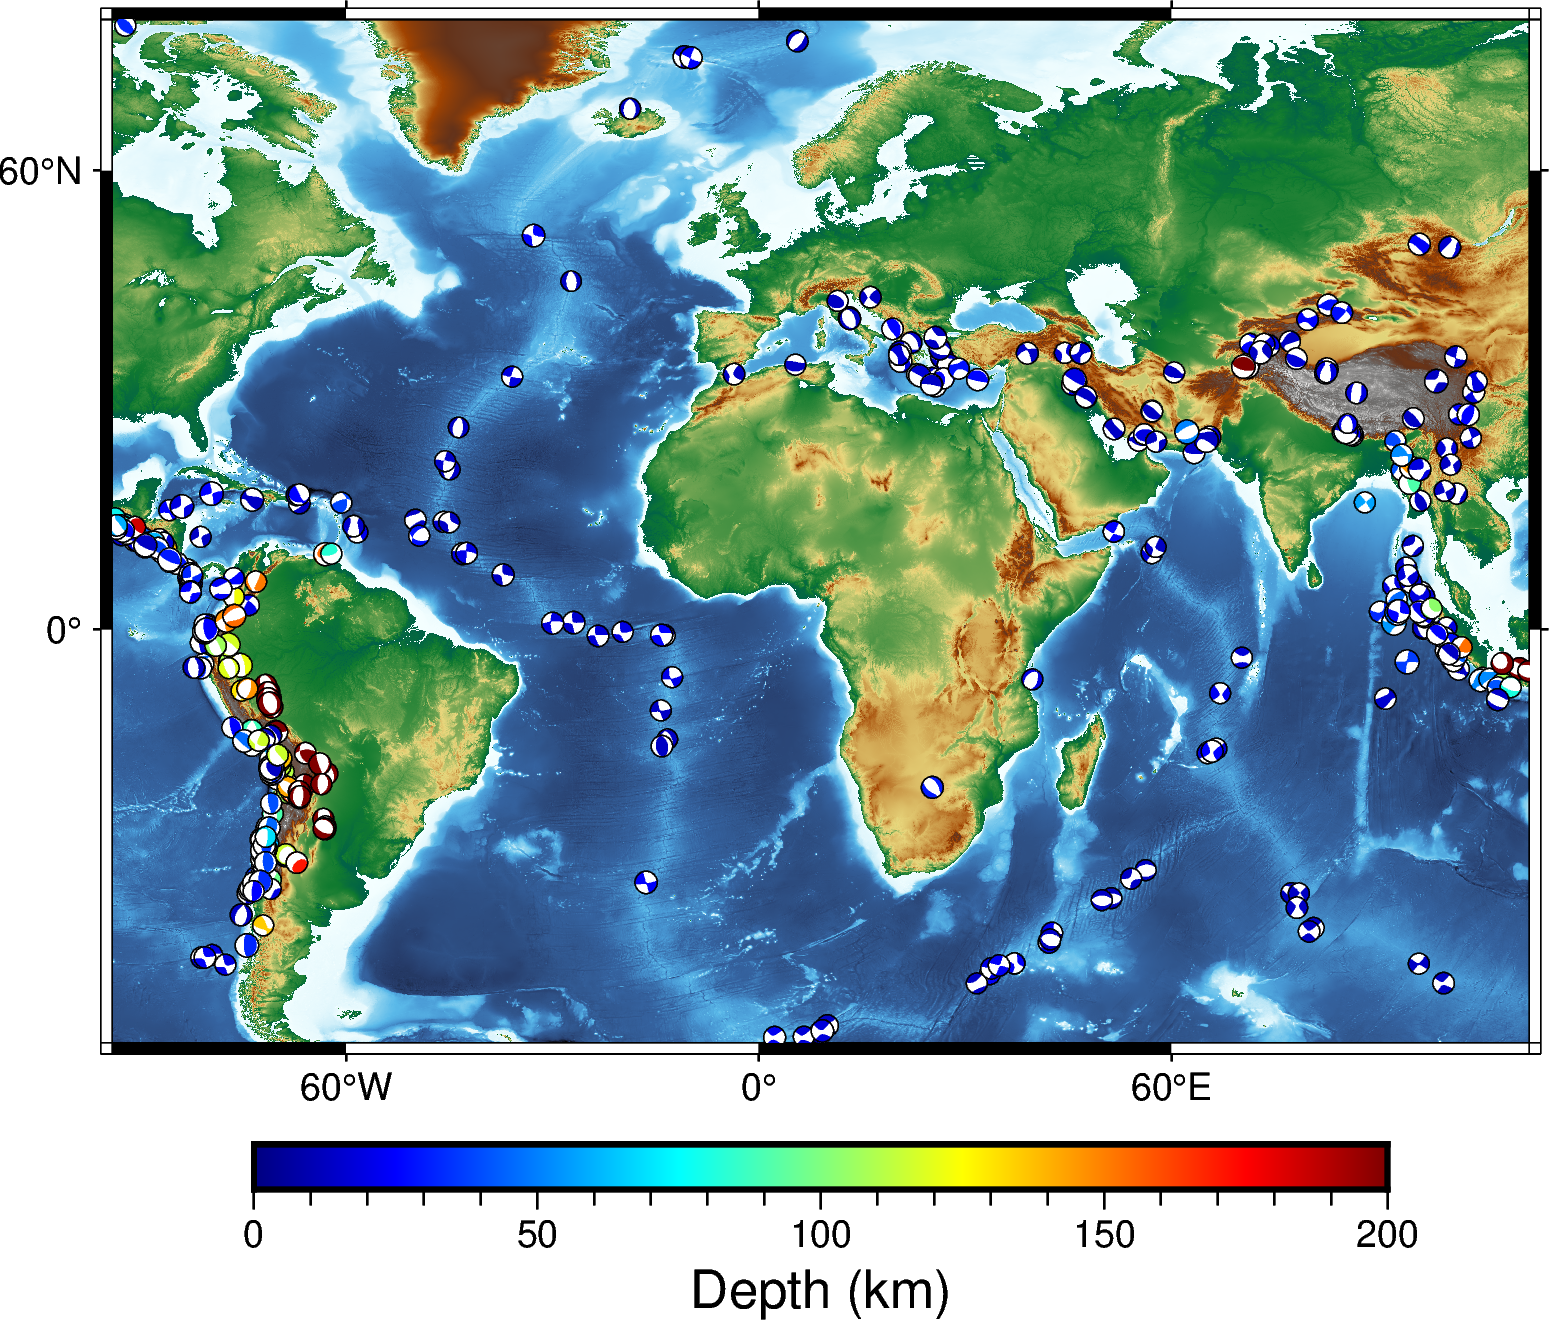

In [3]:
import pygmt
import matplotlib
latcen = (maxlat + minlat)/2; loncen = (maxlon + minlon)/2;
grid = pygmt.datasets.load_earth_relief(resolution="01m", region=[minlon, maxlon, minlat, maxlat])
fig = pygmt.Figure()
pygmt.makecpt(series=[-8000, 8000], cmap='geo')
projection_str = ['Cyl_stere/' + str(loncen) + '/' + str(latcen) + '/12c']
fig.grdimage(grid=grid, projection=projection_str, frame="a", cmap=True)
cat = obspy.read_events('CMTSOLUTIONS')
cmap2 = matplotlib.cm.get_cmap('jet')
for e in range (0, len(cat)):
    moment_tensor = cat[e].focal_mechanisms[0].moment_tensor;
    longitude = cat[e].origins[0].longitude;
    latitude = cat[e].origins[0].latitude;
    depth = cat[e].origins[0].depth;
    mrr = moment_tensor.tensor.m_rr;
    mtt = moment_tensor.tensor.m_tt;
    mpp = moment_tensor.tensor.m_pp;
    mrt = moment_tensor.tensor.m_rt;
    mrp = moment_tensor.tensor.m_rp;
    mtp = moment_tensor.tensor.m_tp;
    mt = [mrr, mtt, mpp, mrt, mrp, mtp];
    rgba = cmap2(depth/200000);
    colorhex = matplotlib.colors.to_hex(rgba, keep_alpha=True)
    focal_mechanism = dict(mrr=mrr, mtt=mtt, mff=mpp, mrt=mrt, mrf=mrp, mtf=mtp, exponent=17);
    fig.meca(focal_mechanism, scale="0.07c", longitude=longitude, latitude=latitude, depth=depth, G=colorhex);
pygmt.makecpt(series=[0, 200], cmap='jet');
fig.colorbar(frame='af+l"Depth (km)"')
fig.show()